## Solution Homework 7, Exercise 1

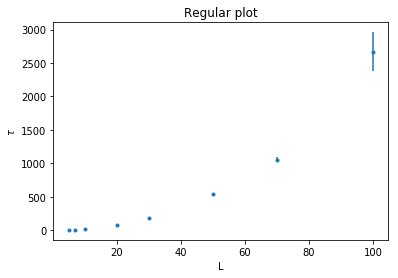

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# read in data and plot it on a regular scale

dataList=[]
source=open('power_law_data.csv',"r")
dataList=source.readlines()
source.close()

L=[]
tau=[]
dtau=[]

for i in range(len(dataList)):
    data=dataList[i]
    dataSplit=data.split(",")
    L.append(float(dataSplit[0]))
    tau.append(float(dataSplit[1]))
    dtau.append(float(dataSplit[2]))

L = np.array(L)
tau = np.array(tau)
dtau = np.array(dtau)
    
plt.errorbar(L, tau, yerr=dtau, fmt='.')
plt.xlabel("L")
plt.ylabel(r"$\tau$")
plt.title("Regular plot")
plt.show()

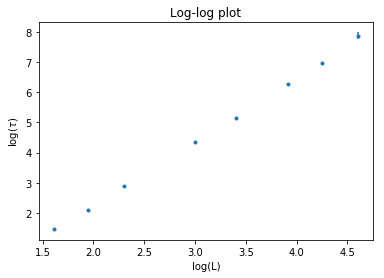

In [46]:
# now plotting on log-log scale
plt.title("Log-log plot")
plt.xlabel("log(L)")
plt.ylabel(r"log$(\tau)$")
plt.errorbar(np.log(L), np.log(tau), yerr=abs(dtau/tau), fmt='.')
plt.show()

chisq_min/dof =  1.126886140878405
Q =  0.3434856859848926
The fit is acceptable!
Best fit:  [-1.96051826  2.1046865 ]


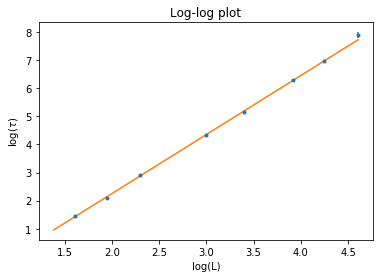

In [48]:
# linear fit of log-log data by direct minimization
from scipy.optimize import minimize
from scipy.special import gammaincc

logX = np.log(L)
logY = np.log(tau)
errLogY = abs(dtau/tau)

def chisq(params):
    a, b = params
    return np.sum( (a + b*logX - logY)**2/errLogY**2 )

initial_guess = [1, 1]
num_points = L.size
dof = num_points - 2
chisq_min = minimize(chisq, initial_guess).fun

print("chisq_min/dof = ", chisq_min/dof)
print("Q = ", gammaincc(dof/2, chisq_min/2))
print("The fit is acceptable!")

plt.errorbar(logX, logY, yerr = errLogY, fmt='.')

best_fit = minimize(chisq, initial_guess).x
x_for_plot = np.arange(4,100,0.01)
plt.plot(np.log(x_for_plot), best_fit[0] + best_fit[1]*np.log(x_for_plot))

print("Best fit: ", best_fit)

plt.title("Log-log plot")
plt.xlabel("log(L)")
plt.ylabel(r"log$(\tau)$")
plt.show()

In [34]:
# explicit formulas (the results agree, as expected)

S = np.sum(1/errLogY/errLogY)
Sx = np.sum(logX/errLogY/errLogY)
Sy = np.sum(logY/errLogY/errLogY)
t = (logX-Sx/S)/errLogY
Stt = np.sum(t*t)

b = np.sum(t*logY/errLogY)/Stt
a = (Sy-Sx*b)/S
error_on_a = np.sqrt((1+Sx*Sx/S/Stt)/S)
error_on_b = np.sqrt(1/Stt)

print("log(a) = ", a, "+-", error_on_a,\
      "\na =      ", np.exp(a), "+-", error_on_a*np.exp(a),\
      "\nb =      ", b, "+-", error_on_b)

log(a) =  -1.9605184613947975 +- 0.041111438231996304 
a =       0.14078541019592195 +- 0.0057878906952359074 
b =       2.1046865695966965 +- 0.013915705081256028


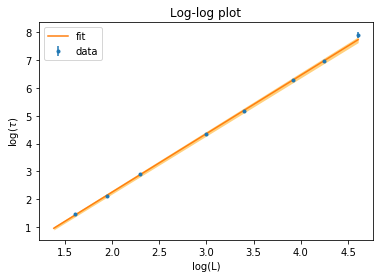

In [51]:
# plotting data on the log-log scale together with linear fit and error band

x_for_logplot = np.log(x_for_plot)
y_for_logplot = a + b*x_for_logplot
upper_error = a + error_on_a + (b + error_on_b)*x_for_logplot
lower_error = a - error_on_a + (b - error_on_b)*x_for_logplot

plt.errorbar(logX, logY, yerr = errLogY, fmt='.', label = "data")
plt.plot(x_for_logplot, y_for_logplot, label = "fit")
plt.fill_between(x_for_logplot, lower_error, upper_error, alpha=0.5, facecolor='orange',edgecolor='white',linewidth=0)

plt.title("Log-log plot")
plt.xlabel("log(L)")
plt.ylabel(r"log$(\tau)$")
plt.legend(loc = "upper left")
plt.show()

Best fit parameters:       [0.14075668 2.10436646]
Errors on fit parameters:  [0.00581565 0.01399051]


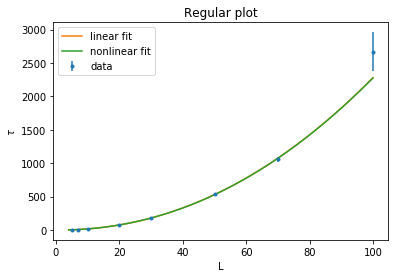

In [52]:
# same with nonlinear fit routine scipy.optimize.curve_fit
# the results agree with the previous fits

from scipy.optimize import curve_fit

def fitf(x, a, b):
    return a*x**(b)

popt, pcov = curve_fit(fitf, L, tau, sigma = dtau, absolute_sigma=True)
print("Best fit parameters:      ", popt)
print("Errors on fit parameters: ", np.sqrt(np.diag(pcov)))

plt.errorbar(L, tau, yerr=dtau, fmt='.', label = "data")
plt.plot(x_for_plot, np.exp(a)*x_for_plot**b, label = "linear fit")
plt.plot(x_for_plot, popt[0]*x_for_plot**popt[1], label = "nonlinear fit")

plt.xlabel("L")
plt.ylabel(r"$\tau$")
plt.title("Regular plot")
plt.legend(loc = "upper left")
plt.show()

## Data and solutions for Homework 7, Exercise 2

In [57]:
# this is how the data points were generated

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaincc
from scipy import linalg

# original function
def f(x):
    return 2.15 - 4.1*x + 7.4*x*x - 1.6*x*x*x

# basis functions for general linear least squares
def basis(x,m):
    return x**m

# generating the data points with errors
num_points = 100
x = np.sort(np.random.rand(num_points)) + 0.3
errY = 0.5*np.random.rand(num_points)
y = np.random.normal(f(x),errY)
x_for_plot = np.linspace(0, 1.4, num_points)

# building the design matrix with dimensions 100 x 4
M = 4
designMatrix = np.zeros((num_points,M))

for i in range(num_points):
    for m in range(M):
        designMatrix[i,m] = basis(x[i],m)/errY[i]

# singular value decomposition
# note that we need option "full_matrices = False" to get the correct matrix dimensions
U, s, Vh = linalg.svd(designMatrix, full_matrices=False)

# check if there are too small singular values (there are not)
print("Singular values:                       ", s)
print("Ratio smallest/largest singular value: ", min(s)/max(s))

# solving for the best fit parameters
vec = y/errY
bestparams = np.dot(np.dot(np.transpose(Vh),np.diag(1/s)),np.dot(np.transpose(U),vec))
errorsparams = np.sqrt(np.dot(1/s,Vh)**2)
print("Best fit paramters:                    ", bestparams)
print("Errors on best fit parameters:         ", errorsparams)

Singular values:                        [4.57037282e+03 1.47982498e+02 1.70383580e+01 6.88377732e-01]
Ratio smallest/largest singular value:  0.0001506174134420498
Best fit paramters:                     [ 2.44165057 -5.40077485  9.19345712 -2.37363166]
Errors on best fit parameters:          [0.15469304 0.76957712 1.11874114 0.49602451]


chisq_min/dof =  0.9938083364323124
Q =  0.49793537532138427
Best fit:  [ 1.86149446 -2.96742952  5.97708149 -1.03227958]


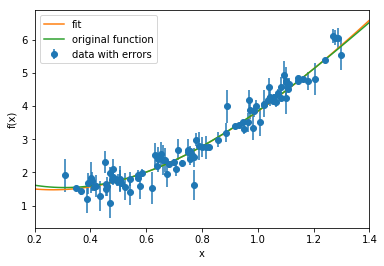

In [18]:
# minimizing chi^2 directly and plots

def chisq(params):
    a, b, c, d = params
    return np.sum( (a + b*x + c*x*x + d*x*x*x - y)**2/errY**2 )

initial_guess = [0.2, -1, 0, 0]
dof = num_points - M
chisq_min = minimize(chisq, initial_guess).fun

# the fit is good
print("chisq_min/dof = ", chisq_min/dof)
print("Q = ", gammaincc(dof/2, chisq_min/2))

plt.errorbar(x, y, yerr = errY, fmt='o', label = "data with errors")

best_fit = minimize(chisq, initial_guess).x
plt.plot(x_for_plot, best_fit[0] + best_fit[1]*x_for_plot +\
         best_fit[2]*x_for_plot*x_for_plot + best_fit[3]*x_for_plot*x_for_plot*x_for_plot, label = "fit")

# The best fit coefficients agree with the previous result
print("Best fit: ", best_fit)

# This was used to save the data
# np.savetxt('general_llsq_data.dat', list(zip(x, y, errY)), fmt='%.5g')

plt.xlim(0.2, 1.4)
plt.plot(x_for_plot,f(x_for_plot), label = "original function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(loc = "upper left")
plt.show()